In [1]:
from pathlib import Path
import numpy as np

In [2]:
folder = Path("/dev/shm/cschlick/CODoutput/")
files = [file for file in folder.glob("**/*") if "geo" in file.name]

In [3]:
import sys
sys.path.append("../phenix_fragments/")

from mol.mols import Mol
from utils.mp import pool_with_progress


In [4]:
mol = Mol.from_file_geocif(files[1000]) # maybe necessary to set class attrs
#atom_input = mol.atoms.atom_input

In [5]:
def worker(file):
  try:
    mol = Mol.from_file_geocif(file)
    rdmol = mol.rdkit_mol
    return mol
  except:
    return None
mols = pool_with_progress(worker,files[:20000],nproc=32)

nproc=32:   1%|█▎                                                                                                             | 229/20000 [00:00<01:03, 311.50it/s][16:10:50] 


nproc=32:   2%|█▊                                                                                                             | 322/20000 [00:00<00:47, 413.17it/s]****
Pre-condition Violation
bond already exists
Violation occurred on line 334 in file /home/conda/feedstock_root/build_artifacts/rdkit_1654409067822/work/Code/GraphMol/RWMol.cpp
Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
****
nproc=32:  53%|█████████████████████████████████████████████████████████▋                                                   | 10585/20000 [00:24<00:13, 692.34it/s][16:11:14] 


****
Pre-condition Violation
bond already exists
Violation occurred on line 334 in file /home/conda/feedstock_root/build_artifacts/rdkit_1654409067822/work/Code/GraphMol/RWMol.cpp
nproc=32:  54%|█████████████████████████████████

In [6]:
mols = [m for m in mols if m!=None]

In [6]:
import sys
sys.path.append("/net/cci-filer3/home/cschlick/Coding/PhenixML/")
from phenixml.featurizers.atom_featurizers import RDKIT_Fingerprint
atom_featurizer = RDKIT_Fingerprint()

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<unsigned int, std::allocator<unsigned int> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.


In [7]:
from graph.message_passing import MessagePassingBonded
from graph.readout import ReadoutSimple
from graph.molgraph import MolGraph, MolGraphDataset
from fragmentation.fragmenters import BondFragmenter, AngleFragmenter
import copy
import tqdm

/net/cci/cschlick/miniconda3/envs/restraintsML/envs/restraintsML6/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
mgraphs = []
failed_mols = []
debug = False
for mol in tqdm.tqdm(mols):
  try:
    mgraph = MolGraph(mol=mol,
                      atom_featurizer=atom_featurizer,
                      fragmenter=AngleFragmenter(exclude_elements=["H"]),
                      labelers = {"angle_value":lambda frags: frags.angle_value},
                                 
                      skip_hydrogens=True,
                      frag_name="fragment")
    mgraphs.append(mgraph)
  except:
    failed_mols.append(mol)
    if debug:
      raise

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:15<00:00, 147.13it/s]


In [10]:
%%time
dataset = MolGraphDataset(mgraphs)
dataset_train, dataset_test = dataset.train_test_split(test_fraction=0.1)
batches = list(dataset_train.batches(batch_size=10000))

CPU times: user 21.3 s, sys: 809 ms, total: 22.1 s
Wall time: 2.57 s


In [11]:
from graph.message_passing import MessagePassingBonded
from graph.readout import ReadoutJanossyLinear
import copy
import torch

In [12]:
# clear_attrs = [label_name+"_pred","h"]+["h%s"%i for i in range(fragment_size)]
# atom_name = "atom"
# fragment_name = "fragment"
# for mgraph in mgraphs:
#   for attr in clear_attrs:
#     if attr in mgraph.fragment_graph.nodes[atom_name].data:
#       if attr != "h0":
#         del mgraph.fragment_graph.nodes[atom_name].data[attr]
#     if attr in mgraph.fragment_graph.nodes[fragment_name].data:
#       del mgraph.fragment_graph.nodes[fragment_name].data[attr]

In [27]:
label_name = "angle_value"
g = dataset_train.fragment_graph
atom_feature_shape = tuple(g.nodes["atom"].data["h0"].shape)
hidden_units = 64
message_passing = MessagePassingBonded(feature_units=atom_feature_shape[1],
                                       hidden_units=hidden_units,
                                       nlayers=4,
                                       )

#readout = ReadoutSimpleLinear(hidden_units*2,hidden_units*2,1,n_hid_layers=1,label_name=label_name)
fragment_size = 3
# readout = ReadoutSimple(hidden_units,
#                         hidden_units,
#                         1,
#                         n_hid_layers=3,
#                         fragment_size=fragment_size,
#                         label_name=label_name)
readout = ReadoutJanossyLinear(hidden_units*fragment_size,
                               hidden_units*fragment_size,
                               1,
                               n_hid_layers=3,
                               label_name=label_name,
                               fragment_size=fragment_size)

model = torch.nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
metric = torch.nn.MSELoss()

In [28]:
batches = list(dataset_train.batches(batch_size=10000))

In [29]:
gpuid = 1
if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

# Training loop
epoch_losses = []
n_epoch=200

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for batch in batches:
    if gpuid is not None:
      batch = batch.to("cuda:"+str(gpuid))
    g = model(batch)
    loss = metric(g.nodes["fragment"].data[label_name],
                  g.nodes["fragment"].data[label_name+"_pred"])
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))
  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.93it/s]


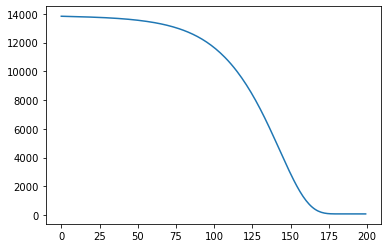

In [30]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)

In [31]:
from utils.torch import to_np, to_torch
from utils.plotting import plot_geom_eval

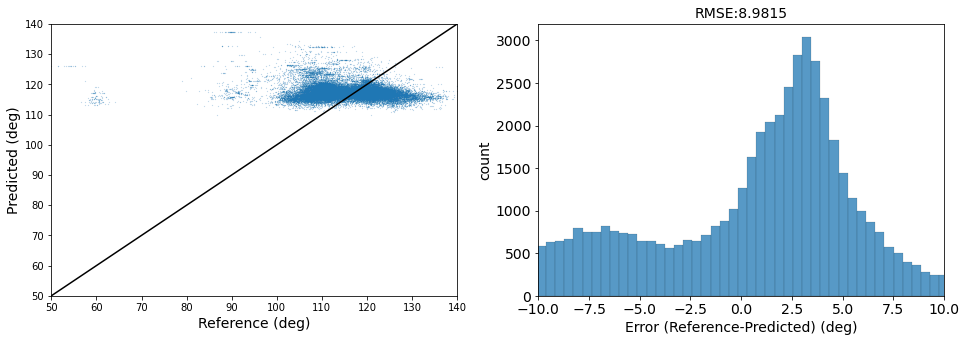

In [32]:
if gpuid is not None:
  model = model.to("cpu")
test_batch = model(dataset_test.fragment_graph)
a,b = (test_batch.nodes["fragment"].data[label_name], 
       test_batch.nodes["fragment"].data[label_name+"_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

In [33]:
! head /net/cci-filer3/home/cschlick/Coding/PhenixML/notebooks/Poster/COD/COD_containers.json

{"MolContainerList": [{"file": "/dev/shm/cschlick/CODoutput/cif/8/10/52/8105236_001_geo.cif", "input_class": "MolInputGeoCifCOD", "accession": {"pdb": null}}, {"file": "/dev/shm/cschlick/CODoutput/cif/8/10/52/8105236_000_geo.cif", "input_class": "MolInputGeoCifCOD", "accession": {"pdb": null}}, {"file": "/dev/shm/cschlick/CODoutput/cif/8/10/52/8105231_001_geo.cif", "input_class": "MolInputGeoCifCOD", "accession": {"pdb": null}}, {"file": "/dev/shm/cschlick/CODoutput/cif/8/10/52/8105231_000_geo.cif", "input_class": "MolInputGeoCifCOD", "accession": {"pdb": null}}, {"file": "/dev/shm/cschlick/CODoutput/cif/8/10/52/8105230_001_geo.cif", "input_class": "MolInputGeoCifCOD", "accession": {"pdb": null}}, {"file": "/dev/shm/cschlick/CODoutput/cif/8/10/52/8105230_000_geo.cif", "input_class": "MolInputGeoCifCOD", "accession": {"pdb": null}}, {"file": "/dev/shm/cschlick/CODoutput/cif/8/10/52/8105225_000_geo.cif", "input_class": "MolInputGeoCifCOD", "accession": {"pdb": null}}, {"file": "/dev/shm/

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



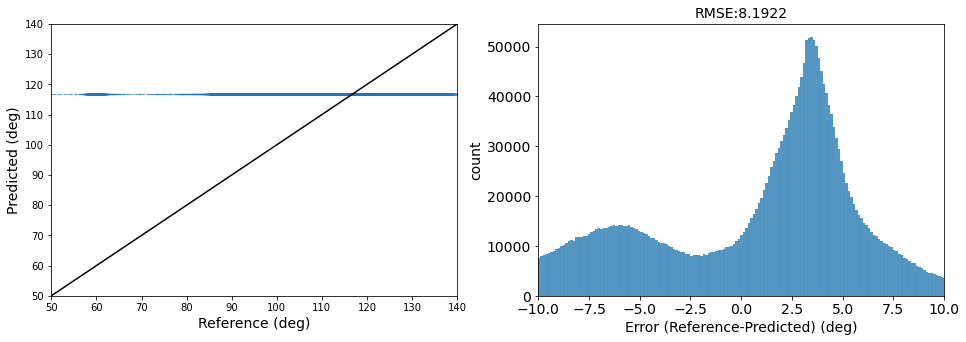

In [28]:
plot_geom_eval(a,b,note="",mode="angle")

In [29]:
b

array([116.77176, 116.77177, 116.77177, ..., 116.77177, 116.77177,
       116.77177], dtype=float32)

In [30]:
a

array([121.401375, 119.75944 , 125.31341 , ..., 124.05855 , 120.091644,
       123.115585], dtype=float32)